In [1]:
"""
import tarfile
import os

archive_path = "./data/cifar-10-python.tar.gz"
extract_path = "./data"

# Extract
with tarfile.open(archive_path, "r:gz") as tar:
    tar.extractall(path=extract_path)


print("Files in data folder after extraction:", os.listdir(extract_path))
"""

'\nimport tarfile\nimport os\n\narchive_path = "./data/cifar-10-python.tar.gz"\nextract_path = "./data"\n\n# Extract\nwith tarfile.open(archive_path, "r:gz") as tar:\n    tar.extractall(path=extract_path)\n\n\nprint("Files in data folder after extraction:", os.listdir(extract_path))\n'

In [ ]:
# Imports that were used, one might need to import certain libraries if they are not installed on your computer
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
# Preprocessing Data
subset_size = 5000
validation_size = int(subset_size/5)
train_size = subset_size - validation_size

batch_size = 50

# Normalize (0, 255) -> (-1, 1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_val_set_full = torchvision.datasets.CIFAR10(root="./data", train=True, download=False, transform=transform)
testset_full = torchvision.datasets.CIFAR10(root="./data", train=False, download=False, transform=transform)


train_val_set = torch.utils.data.Subset(train_val_set_full, range(subset_size))
train_subset, val_subset = torch.utils.data.random_split(train_val_set, [train_size, validation_size])

test_subset = testset_full  

# Batch creation for CNN
cnn_train = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
cnn_val = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
cnn_test = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# SVM needs feature vector, tensor 32x32x3 -> 3072 features
def dataset_to_numpy(dataset):
    X = np.array([np.array(img).flatten() for img, _ in dataset]) # data
    y = np.array([label for _, label in dataset]) # labels
    return X, y

X_train, y_train = dataset_to_numpy(train_subset)
X_val, y_val = dataset_to_numpy(val_subset)
X_test, y_test = dataset_to_numpy(test_subset)

# normalize data for svm
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) # no data leak

print("Training samples:", X_train.shape[0])
print("Input dimensions (features):", X_train.shape[1])
print("Max svm pixel range after scaling:", (X_train.min(), X_train.max()))

Training samples: 4000
Input dimensions (features): 3072
Max svm pixel range after scaling: (-2.209463, 2.6912248)


In [ ]:
# Initializing models

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 3x3 sliding window reuqires 1 extra square each way (padding=1)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10) # 3072 -> 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x)) # (N, 16, 32, 32)
        x = self.pool(F.relu(self.conv2(x))) # 32x32 -> 16x16  (N, 32, 16, 16)
        x = self.pool(x) # 16x16 -> 8x8  (N, 32, 8, 8)
        x = x.view(batch_size, 32 * 8 * 8)  # (N, 32, 8, 8) -> (N, 2048) From here normal FCL
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(x)
        x = x.view(batch_size, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class WideCNN(nn.Module):
    def __init__(self):
        super(WideCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) 
        self.conv2 = nn.Conv2d(32, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = x.view(batch_size, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    


In [ ]:
# Evaluation functions for both val and test

def validation_pca_svm(X_train, y_train, X_val, y_val, pca_components=100, C=1, gamma='scale'):
    pca = PCA(n_components=pca_components)

    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)

    svm_pca = SVC(kernel='rbf', C=C, gamma=gamma) # keep rbf
    svm_pca.fit(X_train_pca, y_train)

    y_pred_pca = svm_pca.predict(X_val_pca)
    svm_acc_pca = accuracy_score(y_val, y_pred_pca) * 100

    return svm_acc_pca

def validation_cnn_setup(model_variant=SimpleCNN, cnn_train=cnn_train, cnn_val=cnn_val, lr=0.001, max_epochs=50, val_interval=4):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_variant().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    print("Training CNN")
    best_val_acc = 0
    final_val_acc = 0
    best_epoch = 0

    start_time = time.time()
    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in cnn_train:

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        normalized_running_loss = running_loss / len(cnn_train)
        print("Running loss for epoch", epoch+1, ":", round(normalized_running_loss, 3))

    
        if (epoch + 1) % val_interval == 0 or epoch == max_epochs-1:
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for images, labels in cnn_val:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_acc = 100 * correct/total
            print("Validation check after epoch", epoch + 1, "- accuracy:", round(val_acc, 3), "%")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                final_val_acc = val_acc
                best_epoch = epoch + 1
            else:
                final_val_acc = val_acc
                print("Stopping early at epoch", epoch+1)
                break

    end_time = time.time()
    print("CNN validation accuracy after ", epoch+1, "epochs:", round(final_val_acc, 3), "%", "with training time ", round(end_time - start_time, 3))
    return final_val_acc, epoch+1

In [ ]:
# Hyperparameter tuning for svm

def grid_search_svm(X_train, y_train, X_val, y_val, pca_components=100, C_values=[0.5, 1, 2, 5], gamma_values=['scale', 0.01, 0.001, 0.0005]):
    best_acc = 0
    best_C = None
    best_gamma = None

    svm_results = []

    for C in C_values:
        for gamma in gamma_values:
            start_time = time.time()
            acc = validation_pca_svm(X_train, y_train, X_val, y_val, pca_components=pca_components, C=C, gamma=gamma)
            end_time = time.time()

            print("PCA components:", pca_components, "C:", C, "Gamma:", gamma, "Validation accuracy:", acc, "% Training time (s):", round(end_time - start_time, 3))

            svm_results.append({"C": C, "gamma": gamma, "val_acc": acc})

            if acc > best_acc:
                best_acc = acc
                best_C = C
                best_gamma = gamma

            

    print("Best SVM parameters for ", pca_components, "PCA components: ", "C:", best_C, "Gamma:", best_gamma, "with accuracy:", best_acc, "%")
    return best_C, best_gamma, best_acc, svm_results

In [ ]:
# Hyperparameter tuning for cnn

def grid_search_cnn(model_variant=SimpleCNN, lr_values=[0.0005, 0.001, 0.005], max_epochs=5):
    best_acc = 0
    best_lr = None

    cnn_results = []

    for lr in lr_values:
        start_time = time.time()
        acc, epochs_used = validation_cnn_setup(model_variant, cnn_train, cnn_val, lr=lr, max_epochs=max_epochs)
        end_time = time.time()
        print("Model variant:", model_variant.__name__, "Learning rate:", lr, "Validation accuracy:", acc, "%", "Training time (s):", round(end_time - start_time, 3))

        cnn_results.append({"lr": lr, "val_acc": acc, "epochs": epochs_used})

        if acc > best_acc:
            best_acc = acc
            best_lr = lr

    print("Best CNN learning rate for model variant: ", model_variant.__name__, "is", best_lr, "with accuracy:", best_acc, "%", " epochs used:", epochs_used)
    return best_lr, best_acc, epochs_used, cnn_results

In [ ]:
# Plot Val acc by lr for cnn

def plot_cnn_results(all_cnn_results):
    for model_name, results in all_cnn_results.items():
        
        df = pd.DataFrame(results)
        df["lr"] = df["lr"].astype(str)
        
        plt.figure(figsize=(8,6))
        plt.bar(df["lr"], df["val_acc"])
        plt.title(f"CNN Validation Accuracy by Learning Rate for {model_name}")
        plt.xlabel("Learning Rate")
        plt.ylabel("Validation Accuracy (%)")
        plt.show()


In [ ]:
# Plot Val acc by hyperparameter heatmap 

def plot_svm_results(all_svm_results):
    for n_components, results in all_svm_results.items():

        df = pd.DataFrame(results)
        pivot_df = df.pivot(index="gamma", columns="C", values="val_acc")
        plt.figure(figsize=(8,6))
        sns.heatmap(pivot_df, annot=True)
        plt.title(f"SVM Validation Accuracy (PCA = {n_components} )")
        plt.xlabel("C")
        plt.ylabel("Gamma")
        plt.show()


In [ ]:
# Perform hyperparameter tuning on cnn

cnn_hyperparams = {}
all_cnn_results = {}

for model in [SimpleCNN, DeepCNN, WideCNN]:
    best_lr, best_acc, best_epochs, cnn_results = grid_search_cnn(model_variant=model, lr_values=[0.0005, 0.001, 0.005], max_epochs=20)
    cnn_hyperparams[model.__name__] = {'lr': best_lr, 'epochs': best_epochs}
    print("Best for model:", model.__name__, "--> learning rate:", best_lr, "epochs:", best_epochs, "\n")

    all_cnn_results[model.__name__] = cnn_results




Training CNN
Running loss for epoch 1 : 2.101
Running loss for epoch 2 : 1.794
Running loss for epoch 3 : 1.64
Running loss for epoch 4 : 1.543
Validation check after epoch 4 - accuracy: 43.4 %
Running loss for epoch 5 : 1.433
Running loss for epoch 6 : 1.352
Running loss for epoch 7 : 1.28
Running loss for epoch 8 : 1.22
Validation check after epoch 8 - accuracy: 49.6 %
Running loss for epoch 9 : 1.162
Running loss for epoch 10 : 1.118
Running loss for epoch 11 : 1.055
Running loss for epoch 12 : 1.006
Validation check after epoch 12 - accuracy: 52.4 %
Running loss for epoch 13 : 0.96
Running loss for epoch 14 : 0.899
Running loss for epoch 15 : 0.845
Running loss for epoch 16 : 0.799
Validation check after epoch 16 - accuracy: 56.1 %
Running loss for epoch 17 : 0.744
Running loss for epoch 18 : 0.704
Running loss for epoch 19 : 0.646
Running loss for epoch 20 : 0.602
Validation check after epoch 20 - accuracy: 54.8 %
Stopping early at epoch 20
CNN validation accuracy after  20 epochs

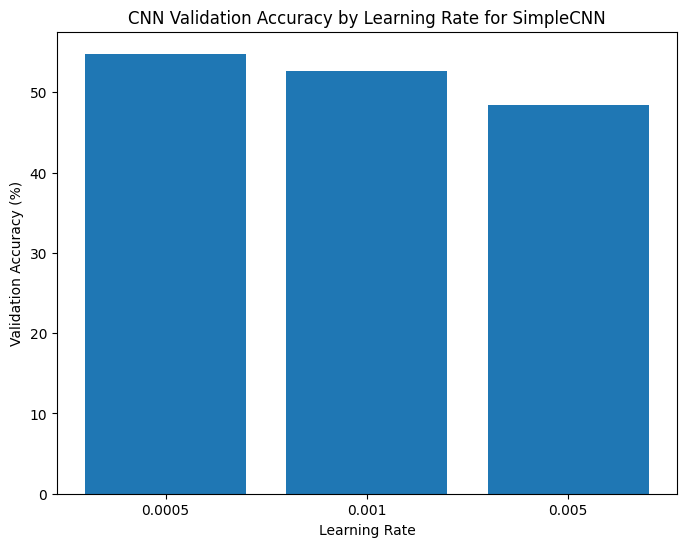

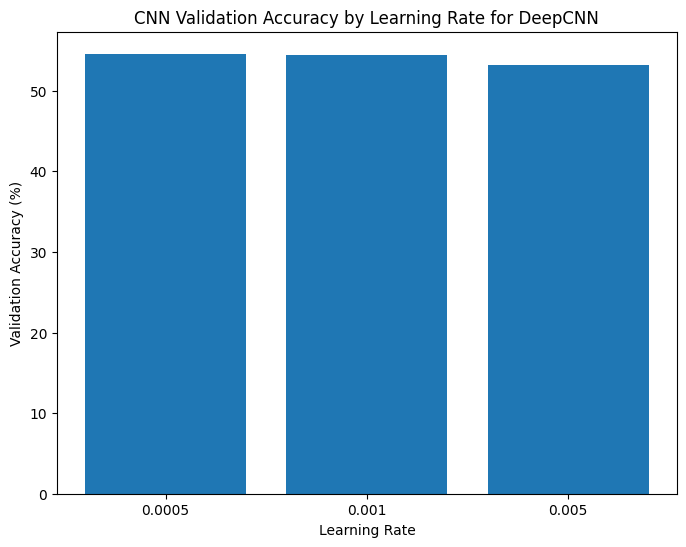

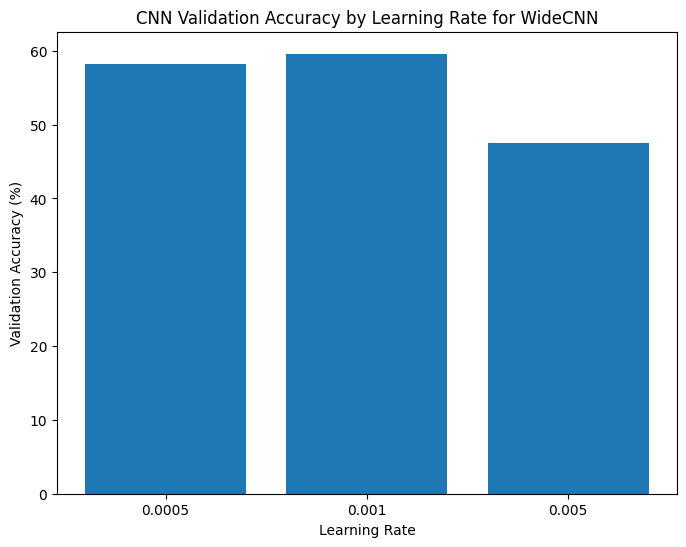

In [13]:
plot_cnn_results(all_cnn_results)

In [ ]:
# Perform hyperparameter tuning on cnn

pca_components_list = [50, 100, 200, 500, 1000]
svm_hyperparams = {}
C_values = [0.1, 1, 10]
gamma_values = [0.01, 0.001, 'scale']

all_svm_results = {}

for n_components in pca_components_list:
    best_C, best_gamma, best_acc, svm_results = grid_search_svm(X_train, y_train, X_val, y_val, pca_components=n_components, C_values=C_values, gamma_values=gamma_values)
    svm_hyperparams[n_components] = {'C': best_C, 'gamma': best_gamma}
    print("Best SVM params for", n_components, "PCA components:", "C:", best_C, "Gamma:", best_gamma, "\n")
    
    all_svm_results[n_components] = svm_results



PCA components: 50 C: 0.1 Gamma: 0.01 Validation accuracy: 10.100000000000001 % Training time (s): 2.654
PCA components: 50 C: 0.1 Gamma: 0.001 Validation accuracy: 26.900000000000002 % Training time (s): 2.429
PCA components: 50 C: 0.1 Gamma: scale Validation accuracy: 26.400000000000002 % Training time (s): 2.471
PCA components: 50 C: 1 Gamma: 0.01 Validation accuracy: 19.8 % Training time (s): 2.689
PCA components: 50 C: 1 Gamma: 0.001 Validation accuracy: 29.7 % Training time (s): 5.731
PCA components: 50 C: 1 Gamma: scale Validation accuracy: 30.8 % Training time (s): 2.924
PCA components: 50 C: 10 Gamma: 0.01 Validation accuracy: 19.400000000000002 % Training time (s): 3.252
PCA components: 50 C: 10 Gamma: 0.001 Validation accuracy: 27.1 % Training time (s): 3.358
PCA components: 50 C: 10 Gamma: scale Validation accuracy: 29.9 % Training time (s): 2.762
Best SVM parameters for  50 PCA components:  C: 1 Gamma: scale with accuracy: 30.8 %
Best SVM params for 50 PCA components: C: 1

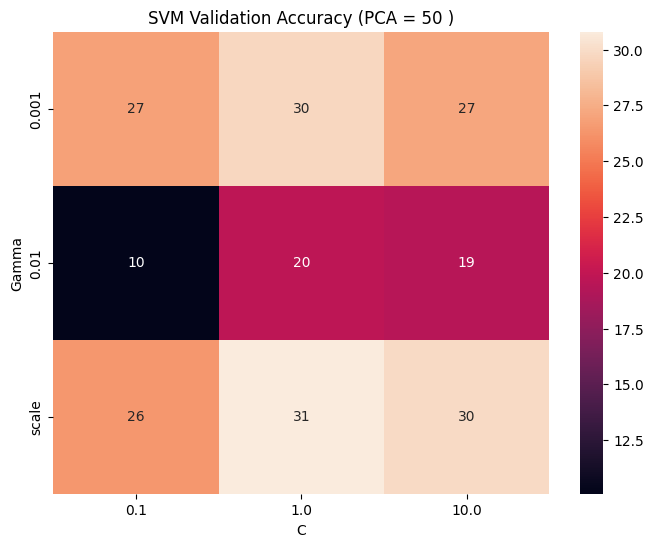

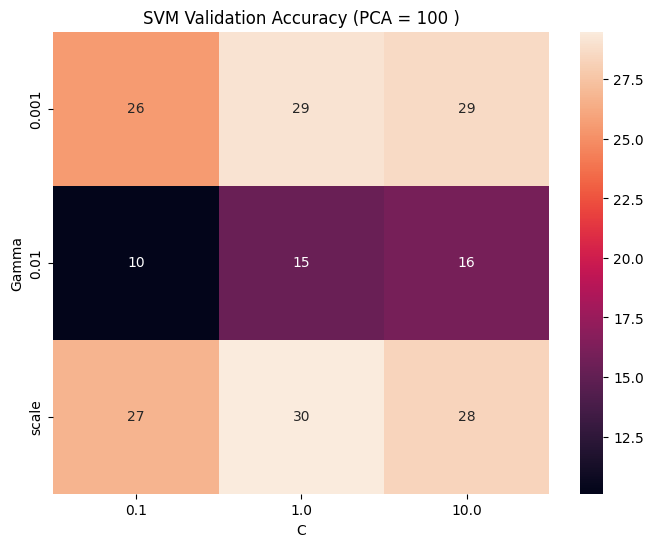

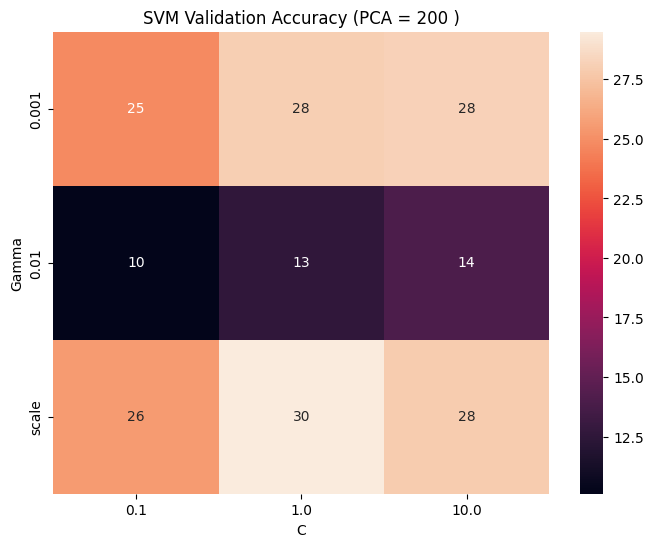

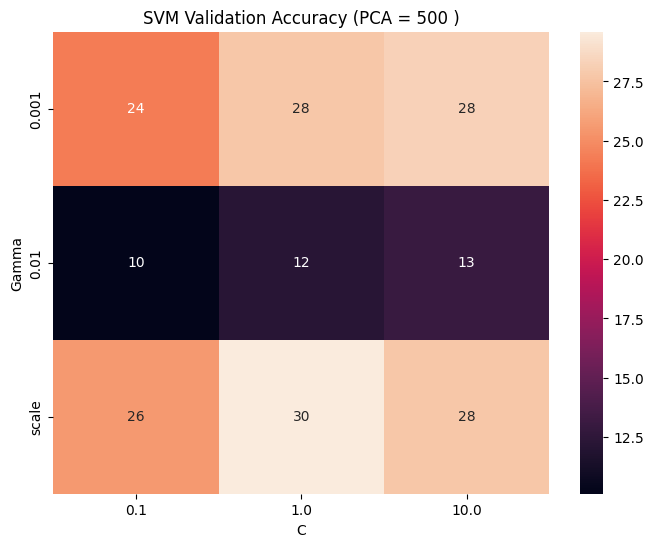

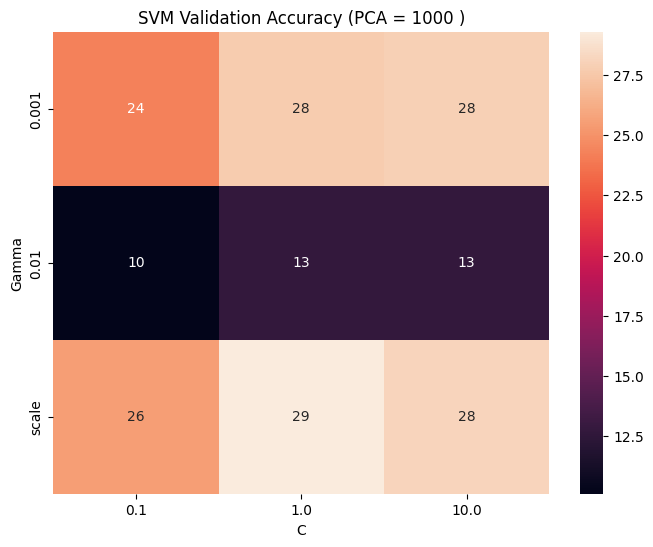

In [15]:
plot_svm_results(all_svm_results)

In [ ]:
# CNN test evaluation

cnn_test_results = {}
cnn_times_dict = {}

for model in [SimpleCNN, DeepCNN, WideCNN]:
    params = cnn_hyperparams[model.__name__]
    print("Evaluating CNN model:", model.__name__)

    start_time = time.time()
    cnn_test_acc, epochs_used = validation_cnn_setup(model_variant=model, cnn_train=cnn_train, cnn_val=cnn_test, lr=params['lr'], max_epochs=params['epochs'])
    end_time = time.time()
    total_time = round(end_time - start_time, 3)

    print("Test accuracy for CNN model", model.__name__, ":", round(cnn_test_acc, 3), "% ", "Training + prediction time (s):", total_time, "\n")

    cnn_test_results[model.__name__] = cnn_test_acc
    cnn_times_dict[model.__name__] = total_time


Evaluating CNN model: SimpleCNN
Training CNN
Running loss for epoch 1 : 2.076
Running loss for epoch 2 : 1.776
Running loss for epoch 3 : 1.581
Running loss for epoch 4 : 1.465
Validation check after epoch 4 - accuracy: 45.81 %
Running loss for epoch 5 : 1.36
Running loss for epoch 6 : 1.282
Running loss for epoch 7 : 1.22
Running loss for epoch 8 : 1.16
Validation check after epoch 8 - accuracy: 50.14 %
Running loss for epoch 9 : 1.1
Running loss for epoch 10 : 1.065
Running loss for epoch 11 : 1.007
Running loss for epoch 12 : 0.974
Validation check after epoch 12 - accuracy: 52.73 %
CNN validation accuracy after  12 epochs: 52.73 % with training time  56.186
Test accuracy for CNN model SimpleCNN : 52.73 %  Training + prediction time (s): 56.197 

Evaluating CNN model: DeepCNN
Training CNN
Running loss for epoch 1 : 2.149
Running loss for epoch 2 : 1.81
Running loss for epoch 3 : 1.657
Running loss for epoch 4 : 1.576
Validation check after epoch 4 - accuracy: 44.3 %
Running loss for

In [17]:
# SVM test evaluation
svm_test_results = {}
svm_times_dict = {}

for n_components in pca_components_list:
    params = svm_hyperparams[n_components]
    print("Evaluating SVM with PCA component count: ", n_components)

    start_time = time.time()
    svm_test_acc = validation_pca_svm(X_train, y_train, X_test, y_test, pca_components=n_components, C=params['C'], gamma=params['gamma'])
    end_time = time.time()
    total_time = round(end_time - start_time, 3)

    print("Test accuracy for SVM with", n_components, "PCA components:", round(svm_test_acc, 3), "% Training + prediction time (s):", total_time, "\n")

    svm_test_results[n_components] = svm_test_acc
    svm_times_dict[n_components] = total_time

Evaluating SVM with PCA component count:  50
Test accuracy for SVM with 50 PCA components: 42.78 % Training + prediction time (s): 8.154 

Evaluating SVM with PCA component count:  100
Test accuracy for SVM with 100 PCA components: 43.31 % Training + prediction time (s): 7.942 

Evaluating SVM with PCA component count:  200
Test accuracy for SVM with 200 PCA components: 43.36 % Training + prediction time (s): 12.272 

Evaluating SVM with PCA component count:  500
Test accuracy for SVM with 500 PCA components: 43.05 % Training + prediction time (s): 24.645 

Evaluating SVM with PCA component count:  1000
Test accuracy for SVM with 1000 PCA components: 43.03 % Training + prediction time (s): 46.073 



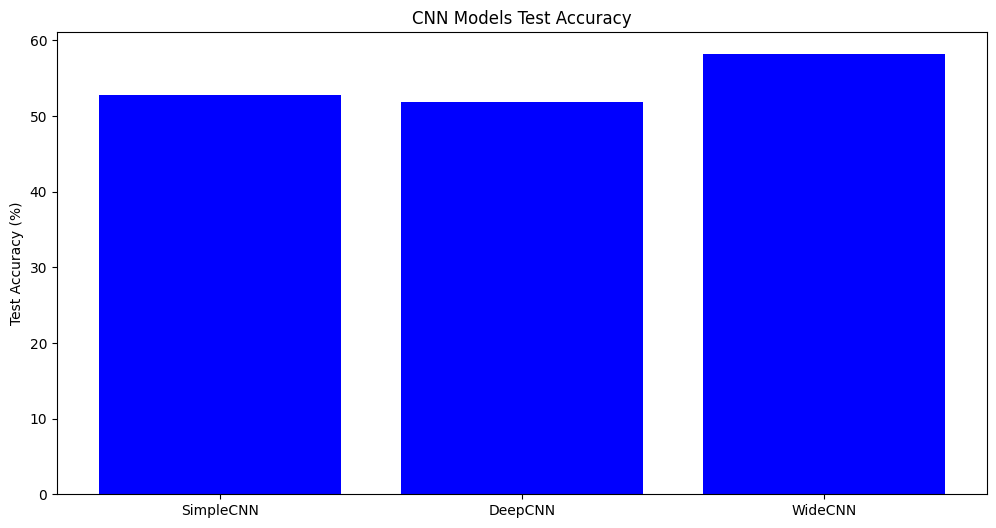

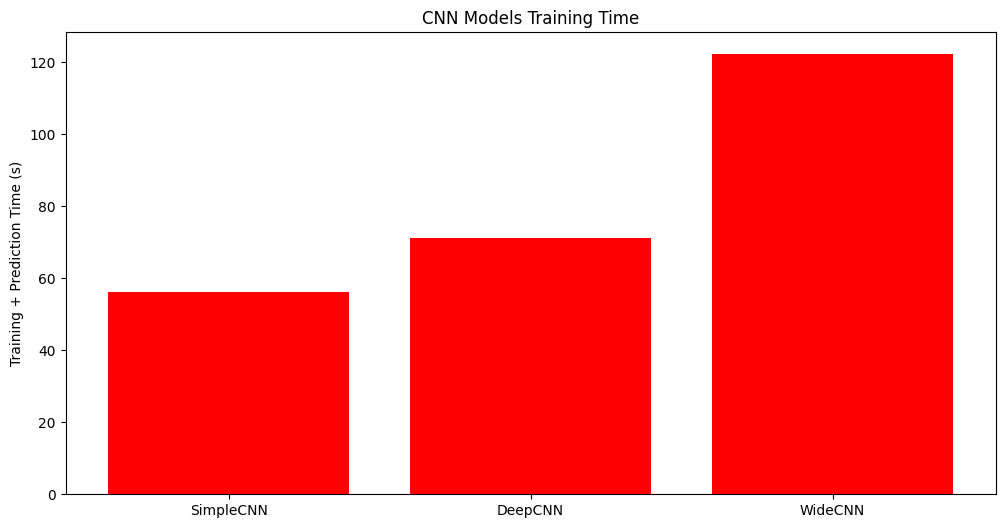

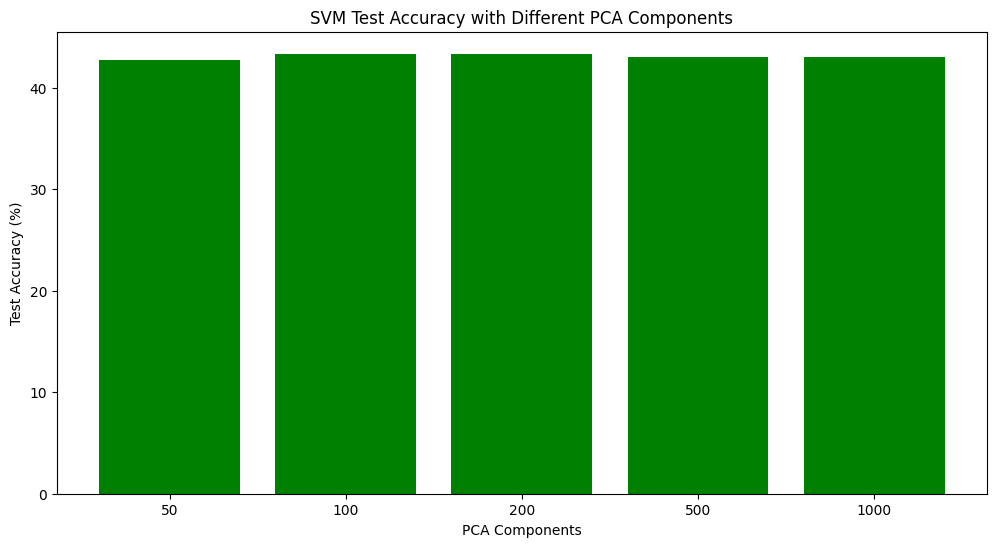

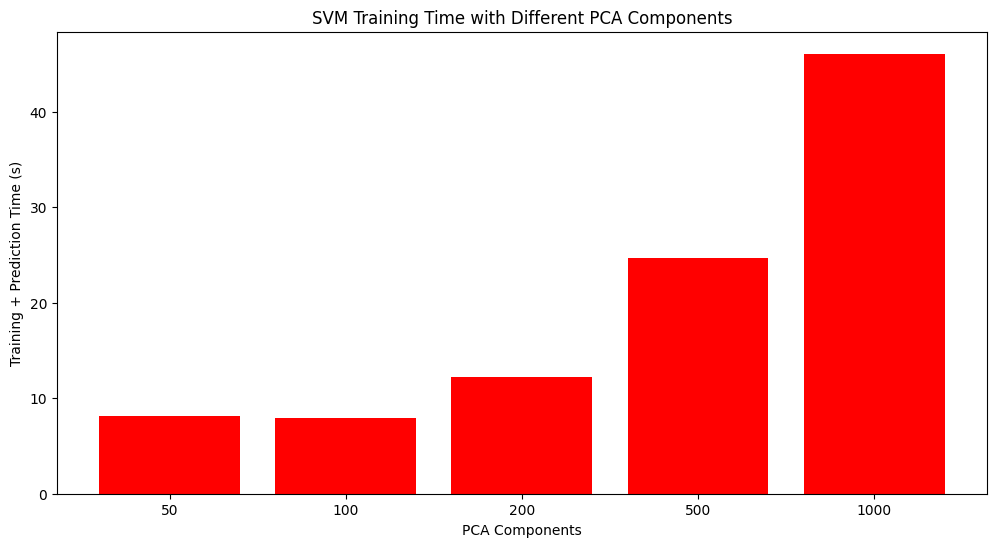

In [ ]:
# Create plots for CNN design experiment
cnn_models = ["SimpleCNN", "DeepCNN", "WideCNN"]
cnn_accs = [cnn_test_results[m] for m in cnn_models]
cnn_times = [cnn_times_dict[m] for m in cnn_models]

plt.figure(figsize=(12,6))
plt.bar(cnn_models, cnn_accs, color="blue")
plt.ylabel("Test Accuracy (%)")
plt.title("CNN Models Test Accuracy")
plt.show()

plt.figure(figsize=(12,6))
plt.bar(cnn_models, cnn_times, color="red")
plt.ylabel("Training + Prediction Time (s)")
plt.title("CNN Models Training Time")
plt.show()

# Create plots for SVM + PCA experiment
pca_comps = [str(c) for c in pca_components_list] 
svm_accs = [svm_test_results[c] for c in pca_components_list]
svm_times = [svm_times_dict[c] for c in pca_components_list]

plt.figure(figsize=(12,6))
plt.bar(pca_comps, svm_accs, color="green")
plt.xlabel("PCA Components")
plt.ylabel("Test Accuracy (%)")
plt.title("SVM Test Accuracy with Different PCA Components")
plt.show()

plt.figure(figsize=(12,6))
plt.bar(pca_comps, svm_times, color="red")
plt.xlabel("PCA Components")
plt.ylabel("Training + Prediction Time (s)")
plt.title("SVM Training Time with Different PCA Components")
plt.show()


In [ ]:
# Setup and run scaling data experiment

subset_sizes = [5000, 10000, 20000]

cnn_scaling_results = {m.__name__: [] for m in [SimpleCNN, DeepCNN, WideCNN]}
svm_scaling_results = {n: [] for n in pca_components_list}

# CNN data scaling
for size in subset_sizes:
    print("CNN training with", size, "samples \n")
    cnn_subset = torch.utils.data.Subset(train_val_set_full, range(size))
    cnn_loader = torch.utils.data.DataLoader(cnn_subset, batch_size=batch_size, shuffle=True)

    for model in [SimpleCNN, DeepCNN, WideCNN]:
        params = cnn_hyperparams[model.__name__]
        start_time = time.time()
        acc, _ = validation_cnn_setup(model_variant=model, cnn_train=cnn_loader, cnn_val=cnn_test, lr=params["lr"], max_epochs=params["epochs"])
        end_time = time.time()

        cnn_scaling_results[model.__name__].append({"train_size": size, "acc": acc, "time": round(end_time - start_time, 3)
        })

        print(model.__name__, "with", size, "samples --> Accuracy:", round(acc, 3), "%  Time:", round(end_time - start_time, 3), "s")


# SVM data scaling
for size in subset_sizes:
    print("SVM training with", size, "samples  \n")
    
    svm_subset = torch.utils.data.Subset(train_val_set_full, range(size))
    X_sub, y_sub = dataset_to_numpy(svm_subset)

    scaler = StandardScaler()
    X_sub = scaler.fit_transform(X_sub)
    X_test_scaled = scaler.transform(X_test)

    for n_components in pca_components_list:
        params = svm_hyperparams[n_components]
        start_time = time.time()
        acc = validation_pca_svm(X_sub, y_sub, X_test, y_test, pca_components=n_components, C=params["C"], gamma=params["gamma"])
        end_time = time.time()

        svm_scaling_results[n_components].append({"train_size": size, "acc": acc, "time": round(end_time - start_time, 3)})

        print("SVM with PCA =", n_components, "and", size, "samples --> Accuracy:", round(acc, 3), "%  Time:", round(end_time - start_time, 3), "s")


CNN training with 5000 samples 

Training CNN
Running loss for epoch 1 : 2.018
Running loss for epoch 2 : 1.666
Running loss for epoch 3 : 1.502
Running loss for epoch 4 : 1.386
Validation check after epoch 4 - accuracy: 48.53 %
Running loss for epoch 5 : 1.311
Running loss for epoch 6 : 1.232
Running loss for epoch 7 : 1.167
Running loss for epoch 8 : 1.11
Validation check after epoch 8 - accuracy: 53.44 %
Running loss for epoch 9 : 1.068
Running loss for epoch 10 : 1.012
Running loss for epoch 11 : 0.969
Running loss for epoch 12 : 0.924
Validation check after epoch 12 - accuracy: 54.77 %
CNN validation accuracy after  12 epochs: 54.77 % with training time  70.328
SimpleCNN with 5000 samples --> Accuracy: 54.77 %  Time: 70.333 s
Training CNN
Running loss for epoch 1 : 2.043
Running loss for epoch 2 : 1.774
Running loss for epoch 3 : 1.621
Running loss for epoch 4 : 1.527
Validation check after epoch 4 - accuracy: 44.08 %
Running loss for epoch 5 : 1.466
Running loss for epoch 6 : 1.3

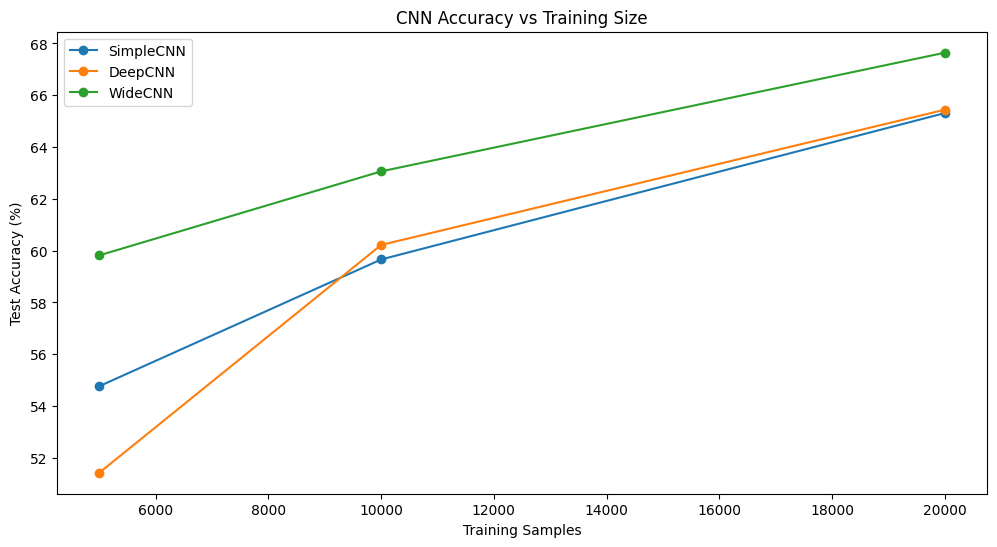

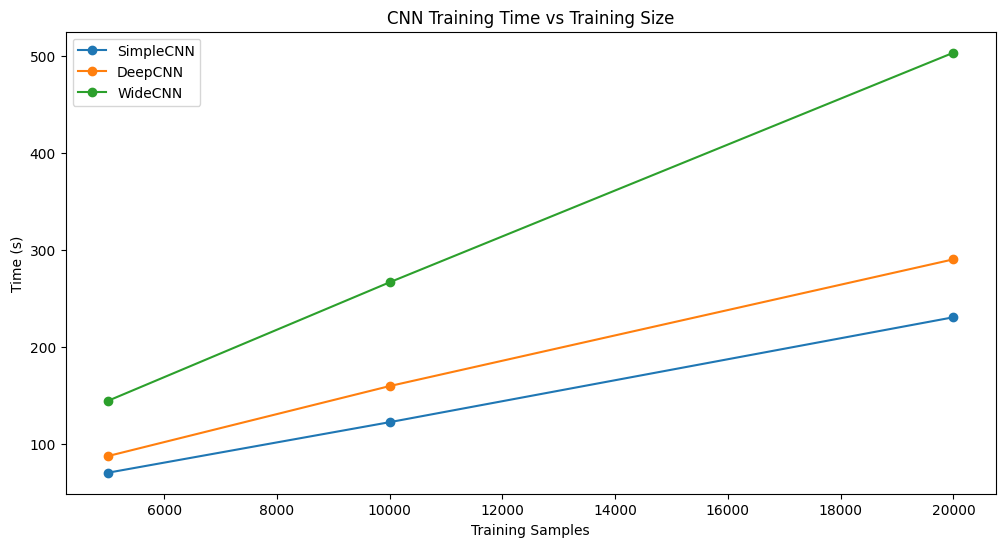

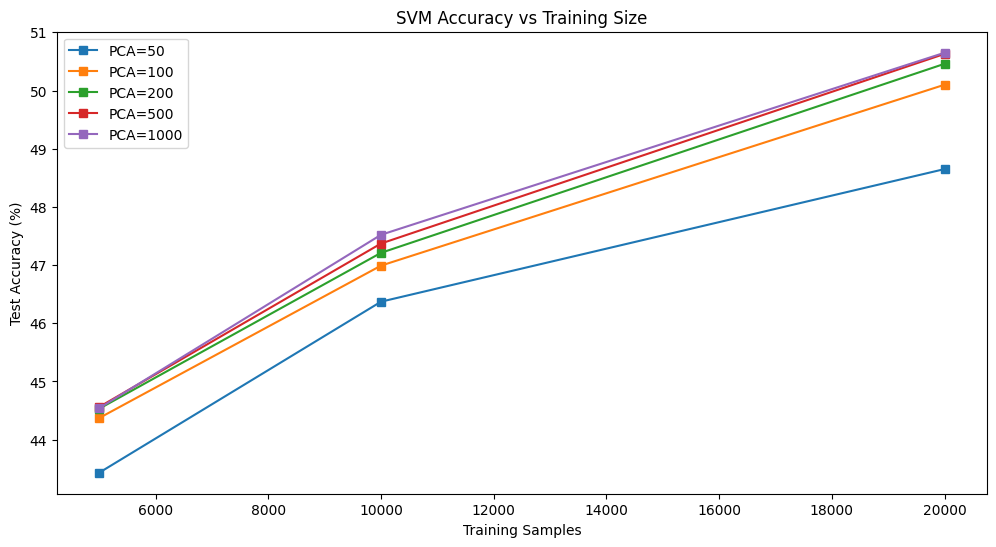

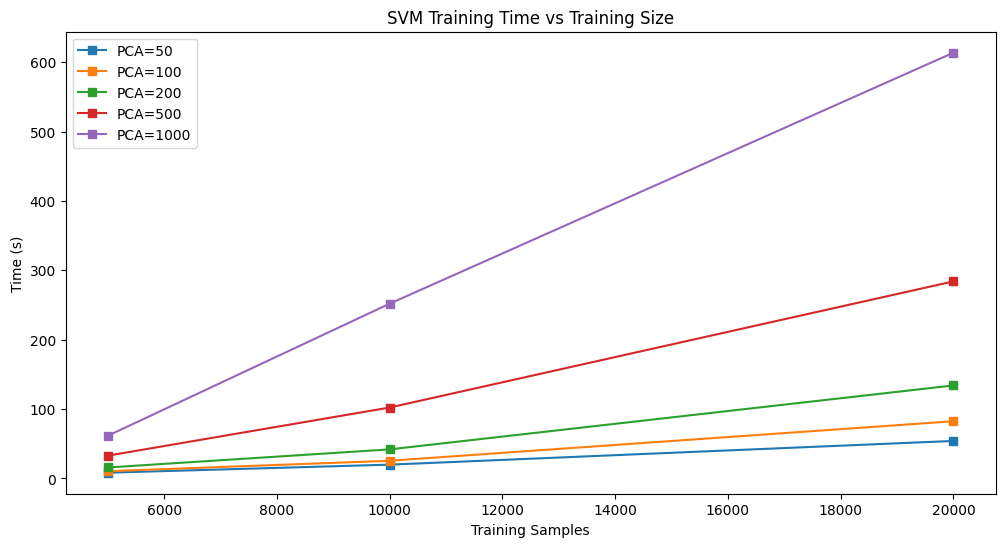

In [ ]:
# Create plots for scaling data experiment

def plot_scaling_results(cnn_results, svm_results):
    plt.figure(figsize=(12,6))
    for model_name, data in cnn_results.items():
        df = pd.DataFrame(data)
        plt.plot(df["train_size"], df["acc"], marker="o", label=model_name)
    plt.title("CNN Accuracy vs Training Size")
    plt.xlabel("Training Samples")
    plt.ylabel("Test Accuracy (%)")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,6))
    for model_name, data in cnn_results.items():
        df = pd.DataFrame(data)
        plt.plot(df["train_size"], df["time"], marker="o", label=model_name)
    plt.title("CNN Training Time vs Training Size")
    plt.xlabel("Training Samples")
    plt.ylabel("Time (s)")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,6))
    for n_components, data in svm_results.items():
        df = pd.DataFrame(data)
        plt.plot(df["train_size"], df["acc"], marker="s", label=f"PCA={n_components}")
    plt.title("SVM Accuracy vs Training Size")
    plt.xlabel("Training Samples")
    plt.ylabel("Test Accuracy (%)")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,6))
    for n_components, data in svm_results.items():
        df = pd.DataFrame(data)
        plt.plot(df["train_size"], df["time"], marker="s", label=f"PCA={n_components}")
    plt.title("SVM Training Time vs Training Size")
    plt.xlabel("Training Samples")
    plt.ylabel("Time (s)")
    plt.legend()
    plt.show()

plot_scaling_results(cnn_scaling_results, svm_scaling_results)